Notes to Group:
* Normalization and transformations are from hw2 p1
* only touched up to classification


# Final Project: Pnuenomia Classification

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,models,datasets
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import scipy
from classifier import Classifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Reading Data

### Loading Training Data

In [2]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

ds_transforms = {
        'train': transforms.Compose([
                    transforms.Resize(227),
                    transforms.CenterCrop(227),
                    transforms.ToTensor(),
                    normalize
                ]),
        'test': transforms.Compose([
                    transforms.Resize(227),
                    transforms.CenterCrop(227),
                    transforms.ToTensor(),
                    normalize,
                ]),
        'validate': transforms.Compose([
                    transforms.Resize(227),
                    transforms.CenterCrop(227),
                    transforms.ToTensor(),
                    normalize,
                ])
        }



### Loading Train, Test, and Validation Data

Load our pneumonia dataset into our program.

In [3]:
ds_dir = {
    'train': 'data/train',
    'test' : 'data/test',
    'validate':  'data/val',
}

ds_set = {
    'train': torchvision.datasets.ImageFolder(ds_dir['train'], ds_transforms['train']),
    'test' : torchvision.datasets.ImageFolder(ds_dir['test'], ds_transforms['test']),
    'validate':  torchvision.datasets.ImageFolder(ds_dir['validate'], ds_transforms['validate']),
}
# Reducing it cause there is some issue with dimentions, 
# I think the classifier gets [10, 3, 227, 227] instead of 10 * [3, 277, 277]
# ds_batch_size = 32
ds_batch_size = 1
ds_loader = {
    'train': torch.utils.data.DataLoader(ds_set['train'], batch_size=ds_batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(ds_set['test'], batch_size=ds_batch_size,shuffle=True),
    'validate': torch.utils.data.DataLoader(ds_set['test'], batch_size=ds_batch_size,shuffle=True),
}
ds_class = {ds_set['validate'].class_to_idx[i]: i for i in list(ds_set['validate'].class_to_idx.keys())}

In [4]:
ds_class

{0: 'NORMAL', 1: 'PNEUMONIA'}

### Visualizing the Data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


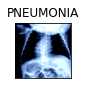

In [5]:
# display 8 images
# num_images = 8
# TODO: Display All 8 Images
num_images = 1

ds_iter = iter(ds_loader['train'])
images, labels = ds_iter.next()
images = images.numpy()

#show the images, set up plt
ds_figure = plt.figure(figsize=(num_images, 4))

for i in np.arange(num_images):
    ds_figure_subplot = ds_figure.add_subplot(2, 1, i+1, xticks=[], yticks=[]) #remove ticks and change layout
#     ds_figure_subplot = ds_figure.add_subplot(2, num_images/2, i+1, xticks=[], yticks=[]) #remove ticks and change layout
    image = np.transpose(images[i])
    image = np.rot90(np.rot90(np.rot90(image)))#rotate images to be up right
    
    plt.imshow(image) #show image
    ds_figure_subplot.set_title(ds_class[labels.tolist()[i]]) #add title of normal or pneumonia

# Classification

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# ds_train = iter(ds_loader['train'])
# train_loader = torch.utils.data.DataLoader(dataset=ds_train,
#                                                batch_size=2, 
#                                                shuffle=True,
#                                                num_workers=1)

In [8]:
# ds_val = iter(ds_loader['validate'])
# val_loader = torch.utils.data.DataLoader(dataset=ds_val,
#                                                batch_size=2, 
#                                                shuffle=True,
#                                                num_workers=1)

In [9]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        # TODO: Fix One Hot Encoding for Batches
        labels = torch.nn.functional.one_hot(labels, 2)
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [10]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,2))
        y_score = np.zeros((0,2))
#         y_true = np.zeros((0,21))
#         y_score = np.zeros((0,21))
        for i, (images, labels) in enumerate(test_loader):
            # TODO: Fix One Hot Encoding for Batches
            labels = torch.nn.functional.one_hot(labels, 2)
            images, labels = images.to(device), labels.to(device).float()
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
        aps = []
        for i in range(y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
#                 print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(ds_class[i], ap))
            aps.append(ap)
            
        aps = np.array(aps)
        mAP = np.mean(aps)
        test_loss = torch.mean(torch.stack(losses))
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## [TODO Remove This] Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [11]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [12]:
# TODO: Use a different loss
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=45, gamma=0.1)

In [13]:
for images, labels in ds_loader['train']:
    print(torch.nn.functional.one_hot(labels, 2))
    break

tensor([[0, 1]])


In [14]:
# Training the Classifier
# NUM_EPOCHS = 100
NUM_EPOCHS = 6
TEST_FREQUENCY = 3

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(ds_loader['train'], classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    scheduler.step()
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(ds_loader['validate'], classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        print("val_loss for Testing on Epoch " +str(epoch) + " is "+ str(val_loss))
        

Starting epoch number 1
Loss for Training on Epoch 1 is 0.10825250297784805
Starting epoch number 2
Loss for Training on Epoch 2 is 0.10673418641090393
Starting epoch number 3
Loss for Training on Epoch 3 is 0.10819513350725174
-------  Class: NORMAL           AP:   0.3750  -------
-------  Class: PNEUMONIA        AP:   0.6250  -------
mAP: 0.5000
Avg loss: 0.12145280838012695
Evaluating classifier
Mean Precision Score for Testing on Epoch 3 is 0.5
val_loss for Testing on Epoch 3 is tensor(0.1215, device='cuda:0')
Starting epoch number 4
Loss for Training on Epoch 4 is 0.10770543664693832
Starting epoch number 5
Loss for Training on Epoch 5 is 0.1084601953625679
Starting epoch number 6
Loss for Training on Epoch 6 is 0.10751761496067047
-------  Class: NORMAL           AP:   0.3750  -------
-------  Class: PNEUMONIA        AP:   0.6250  -------
mAP: 0.5000
Avg loss: 0.11726999282836914
Evaluating classifier
Mean Precision Score for Testing on Epoch 6 is 0.5
val_loss for Testing on Epoc

In [15]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier.pth')

# Evaluate on test set



In [16]:
# ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

# test_loader = torch.utils.data.DataLoader(dataset=ds_test,
#                                                batch_size=50, 
#                                                shuffle=False,
#                                                num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(ds_loader['test'], classifier, criterion)

-------  Class: NORMAL           AP:   0.3750  -------
-------  Class: PNEUMONIA        AP:   0.6250  -------
mAP: 0.5000
Avg loss: 0.11726998537778854


In [17]:
# output_submission_csv('my_solution.csv', test_aps)